[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/pralab/secml/blob/HEAD/tutorials/01-Training.ipynb)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow.keras.backend as K
import tensorflow
tensorflow.device('/device:GPU:0')
device_name = tensorflow.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))

from tensorflow.keras import layers
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, concatenate, LeakyReLU, Reshape, Lambda, BatchNormalization, Dropout
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D

from tensorflow.keras.optimizers import SGD

Found GPU at: /device:GPU:0


# Data loading and preparation

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [ ]:
x_train = x_train[(y_train == 2) | (y_train ==7)]
y_train = y_train[(y_train == 2) | (y_train ==7)]
x_test = x_test[(y_test == 2) | (y_test ==7)]
y_test = y_test[(y_test == 2) | (y_test ==7)]

In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255.0
x_test = x_test / 255.0

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [ ]:
input_shape = x_train.shape[1:]
number_layers = 128
latent_dim = 128

In [ ]:
x_train, x_val, y_train_cat, y_val_cat = train_test_split(x_train, y_train_cat, test_size=0.2, random_state=42)
x_val, x_test, y_val_cat, y_test_cat = train_test_split(x_val, y_val_cat, test_size=0.5, random_state=42)

In [ ]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(40000, 32, 32, 3)
(5000, 32, 32, 3)
(5000, 32, 32, 3)


# CNN for image classification

In [ ]:
def define_CNN_model():

	model = Sequential()
	model.add(Conv2D(number_layers, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
	model.add(MaxPooling2D((2, 2)))
	model.add(BatchNormalization())
	model.add(Dropout(0.2))
 
	model.add(Conv2D(number_layers*2, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(BatchNormalization())
	model.add(Dropout(0.2))
 
	model.add(Conv2D(number_layers*4, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(BatchNormalization())
	model.add(Dropout(0.2))
 
	model.add(Flatten())
	model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
 
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
model = define_CNN_model()

history = model.fit(x_train, y_train_cat, epochs=30, shuffle=True, validation_data=(x_val, y_val_cat), batch_size=32, verbose=1)

Epoch 1/30
1250/1250 [==============================] - 27s 21ms/step - loss: 1.5026 - accuracy: 0.4890 - val_loss: 1.2557 - val_accuracy: 0.5496
Epoch 2/30
1250/1250 [==============================] - 25s 20ms/step - loss: 1.0780 - accuracy: 0.6254 - val_loss: 1.1138 - val_accuracy: 0.6218
Epoch 3/30
1250/1250 [==============================] - 24s 20ms/step - loss: 0.8961 - accuracy: 0.6887 - val_loss: 1.1516 - val_accuracy: 0.6316
Epoch 4/30
1250/1250 [==============================] - 25s 20ms/step - loss: 0.7722 - accuracy: 0.7302 - val_loss: 0.9070 - val_accuracy: 0.7048
Epoch 5/30
1250/1250 [==============================] - 25s 20ms/step - loss: 0.6612 - accuracy: 0.7694 - val_loss: 0.9160 - val_accuracy: 0.6976
Epoch 6/30
1250/1250 [==============================] - 25s 20ms/step - loss: 0.5722 - accuracy: 0.8022 - val_loss: 0.9906 - val_accuracy: 0.7028
Epoch 7/30
1250/1250 [==============================] - 25s 20ms/step - loss: 0.4862 - accuracy: 0.8300 - val_loss: 0.8285 -

In [ ]:
def show_performance(history):
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

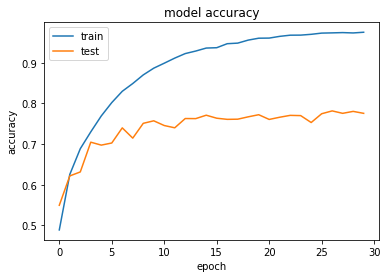

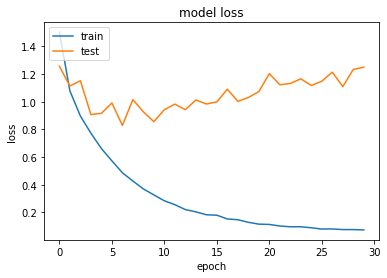

In [ ]:
show_performance(history)

In [ ]:
y_pred = model.predict(x_test)

y_pred = to_categorical(np.argmax(y_pred,axis=1))

print(classification_report(y_test_cat, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.72      0.77       491
           1       0.91      0.83      0.87       475
           2       0.72      0.68      0.70       536
           3       0.60      0.55      0.57       504
           4       0.66      0.85      0.74       472
           5       0.74      0.61      0.67       520
           6       0.78      0.86      0.82       481
           7       0.82      0.80      0.81       513
           8       0.78      0.89      0.83       482
           9       0.81      0.86      0.83       526

   micro avg       0.76      0.76      0.76      5000
   macro avg       0.76      0.76      0.76      5000
weighted avg       0.76      0.76      0.76      5000
 samples avg       0.76      0.76      0.76      5000



# Autoencoder 1

In [ ]:
input_img = Input(shape=input_shape)

x = Conv2D(number_layers, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(number_layers*2, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(number_layers*4, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(number_layers*8, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

encoded = MaxPooling2D((2, 2), padding='same', name='embedding')(x)

# at this point the representation is (2, 2, number_layer*8)

x = Conv2D(number_layers*8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(number_layers*4, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(number_layers*2, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(number_layers, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
#autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 128)      512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 256)      1024  

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val, x_val),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/30
313/313 [==============================] - 42s 112ms/step - loss: 0.0216 - val_loss: 0.0418
Epoch 2/30
313/313 [==============================] - 29s 91ms/step - loss: 0.0117 - val_loss: 0.0118
Epoch 3/30
313/313 [==============================] - 28s 91ms/step - loss: 0.0092 - val_loss: 0.0094
Epoch 4/30
313/313 [==============================] - 29s 92ms/step - loss: 0.0076 - val_loss: 0.0086
Epoch 5/30
313/313 [==============================] - 28s 91ms/step - loss: 0.0066 - val_loss: 0.0083
Epoch 6/30
313/313 [==============================] - 28s 91ms/step - loss: 0.0060 - val_loss: 0.0073
Epoch 7/30
313/313 [==============================] - 28s 91ms/step - loss: 0.0055 - val_loss: 0.0064
Epoch 8/30
313/313 [==============================] - 28s 91ms/step - loss: 0.0051 - val_loss: 0.0058
Epoch 9/30
313/313 [==============================] - 28s 91ms/step - loss: 0.0049 - val_loss: 0.0064
Epoch 10/30
313/313 [==============================] - 29s 92ms/step - loss: 0.00

In [ ]:
last_layer = autoencoder.get_layer('embedding').output

x = Flatten()(last_layer)
x = Dense(512, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(10, activation='softmax')(x)

autoencoder.trainable = False

fine_tune_model = Model(inputs=autoencoder.input, outputs=x)

opt = SGD(learning_rate=0.01, momentum=0.9)
fine_tune_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
fine_tune_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 128)      512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 256)      1024

In [ ]:
fine_tune_model.fit(x_train, y_train_cat, epochs=20, validation_data=(x_val, y_val_cat), batch_size=32, verbose=1)

Epoch 1/20
1250/1250 [==============================] - 10s 7ms/step - loss: 1.4617 - accuracy: 0.4749 - val_loss: 1.2129 - val_accuracy: 0.5750
Epoch 2/20
1250/1250 [==============================] - 9s 7ms/step - loss: 1.2042 - accuracy: 0.5710 - val_loss: 1.2661 - val_accuracy: 0.5588
Epoch 3/20
1250/1250 [==============================] - 8s 7ms/step - loss: 1.0947 - accuracy: 0.6143 - val_loss: 1.1706 - val_accuracy: 0.5926
Epoch 4/20
1250/1250 [==============================] - 9s 7ms/step - loss: 1.0299 - accuracy: 0.6336 - val_loss: 1.1979 - val_accuracy: 0.6010
Epoch 5/20
1250/1250 [==============================] - 9s 7ms/step - loss: 0.9647 - accuracy: 0.6608 - val_loss: 1.2417 - val_accuracy: 0.5800
Epoch 6/20
1250/1250 [==============================] - 9s 7ms/step - loss: 0.9063 - accuracy: 0.6787 - val_loss: 1.1751 - val_accuracy: 0.6240
Epoch 7/20
1250/1250 [==============================] - 8s 7ms/step - loss: 0.8552 - accuracy: 0.6974 - val_loss: 1.1994 - val_accuracy

In [ ]:
del test_model
K.clear_session()

# Autoencoder 2

* Linear
* (4,4)

In [ ]:
input_img = Input(shape=input_shape)

x = Conv2D(number_layers, (4, 4), activation='linear', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(number_layers*2, (4, 4), activation='linear', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(number_layers*4, (4, 4), activation='linear', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(number_layers*8, (4, 4), activation='linear', padding='same')(x)
x = BatchNormalization()(x)

encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (2, 2, number_layer*8)

x = Conv2D(number_layers*8, (4, 4), activation='linear', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(number_layers*4, (4, 4), activation='linear', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(number_layers*2, (4, 4), activation='linear', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(number_layers, (4, 4), activation='linear', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

decoded = Conv2D(3, (4, 4), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
#autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val, x_val),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

In [ ]:
encoder = Model(input_img, encoded)
last_layer = encoder.output

x = Flatten()(last_layer)
x = Dense(1024, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(10, activation='softmax')(x)

encoder.trainable = False

fine_tune_model = Model(inputs=encoder.input, outputs=x)

opt = SGD(learning_rate=0.01, momentum=0.9)
fine_tune_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
fine_tune_model.fit(x_train, y_train_cat, epochs=20, validation_data=(x_val, y_val_cat), batch_size=32, verbose=1)

Epoch 1/20
313/313 [==============================] - 15s 46ms/step - loss: 1.8623 - accuracy: 0.3294 - val_loss: 1.7071 - val_accuracy: 0.3783
Epoch 2/20
313/313 [==============================] - 9s 29ms/step - loss: 1.5985 - accuracy: 0.4296 - val_loss: 1.5891 - val_accuracy: 0.4331
Epoch 3/20
313/313 [==============================] - 14s 44ms/step - loss: 1.4975 - accuracy: 0.4670 - val_loss: 1.5730 - val_accuracy: 0.4272
Epoch 4/20
313/313 [==============================] - 9s 29ms/step - loss: 1.4206 - accuracy: 0.4876 - val_loss: 1.5464 - val_accuracy: 0.4579
Epoch 5/20
313/313 [==============================] - 14s 44ms/step - loss: 1.3581 - accuracy: 0.5133 - val_loss: 1.4600 - val_accuracy: 0.4767
Epoch 6/20
313/313 [==============================] - 14s 44ms/step - loss: 1.2798 - accuracy: 0.5367 - val_loss: 1.4468 - val_accuracy: 0.4895
Epoch 7/20
313/313 [==============================] - 9s 30ms/step - loss: 1.2262 - accuracy: 0.5545 - val_loss: 1.5452 - val_accuracy: 0.

In [ ]:
del test_model
K.clear_session()

# Autoencoder with two outputs (Construction loss + Classification task)

In [ ]:
input_img = Input(shape=input_shape)

x = Conv2D(number_layers, (4, 4), activation='linear', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(number_layers*2, (4, 4), activation='linear', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(number_layers*4, (4, 4), activation='linear', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(number_layers*8, (4, 4), activation='linear', padding='same')(x)
x = BatchNormalization()(x)

encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (2, 2, number_layer*8)

x = Conv2D(number_layers*8, (4, 4), activation='linear', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(number_layers*4, (4, 4), activation='linear', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(number_layers*2, (4, 4), activation='linear', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(number_layers, (4, 4), activation='linear', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

decoded = Conv2D(3, (4, 4), activation='sigmoid', padding='same', name='decoded')(x)

reg_dense = Flatten()(encoded)
reg_dense = Dense(64, activation='relu')(reg_dense)
reg_dense = Dense(16, activation='relu')(reg_dense) 
class_output = Dense(10, activation='softmax', name='class_output')(reg_dense)

autoencoder = Model(inputs=input_img, outputs=[decoded,class_output])

losses ={ 'decoded':keras.losses.MeanSquaredError(),
    'class_output':keras.losses.CategoricalCrossentropy()}

autoencoder.compile(optimizer='adam', loss=losses, metrics="accuracy")

In [ ]:
autoencoder.fit(x=x_train, y={'decoded': x_train, 'class_output': y_train_cat},
                epochs=20,
                batch_size=64,
                shuffle=True,
                validation_data=(x_val, {'decoded': x_val, 'class_output': y_val_cat}),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/20
625/625 [==============================] - 205s 307ms/step - loss: 1.7939 - decoded_loss: 0.0322 - class_output_loss: 1.7617 - decoded_accuracy: 0.5490 - class_output_accuracy: 0.3693 - val_loss: 1.5223 - val_decoded_loss: 0.0392 - val_class_output_loss: 1.4831 - val_decoded_accuracy: 0.3781 - val_class_output_accuracy: 0.4740
Epoch 2/20
625/625 [==============================] - 192s 307ms/step - loss: 1.2532 - decoded_loss: 0.0216 - class_output_loss: 1.2316 - decoded_accuracy: 0.6408 - class_output_accuracy: 0.5639 - val_loss: 1.6265 - val_decoded_loss: 0.0397 - val_class_output_loss: 1.5869 - val_decoded_accuracy: 0.6197 - val_class_output_accuracy: 0.4804
Epoch 3/20
625/625 [==============================] - 195s 312ms/step - loss: 1.0024 - decoded_loss: 0.0187 - class_output_loss: 0.9838 - decoded_accuracy: 0.6658 - class_output_accuracy: 0.6529 - val_loss: 1.4761 - val_decoded_loss: 0.0217 - val_class_output_loss: 1.4544 - val_decoded_accuracy: 0.6675 - val_class_outp

# Variational Autoencoder

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tensorflow.shape(z_mean)[0]
        dim = tensorflow.shape(z_mean)[1]
        epsilon = tensorflow.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tensorflow.exp(0.5 * z_log_var) * epsilon

In [ ]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tensorflow.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tensorflow.reduce_mean(
                tensorflow.reduce_sum(
                    keras.losses.mean_squared_error(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tensorflow.square(z_mean) - tensorflow.exp(z_log_var))
            kl_loss = tensorflow.reduce_mean(tensorflow.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
encoder_inputs = Input(shape=input_shape)

x = Conv2D(number_layers, (4, 4), padding='same')(encoder_inputs)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(number_layers*2, (4, 4), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(number_layers*4, (4, 4), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(number_layers*8, (4, 4), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Flatten()(x)
x = Dense(256)(x)
x = LeakyReLU(alpha=0.2)(x)

z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Sampling(name="embedding")([z_mean, z_log_var])

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 32, 32, 128)  6272        ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 128)  0           ['conv2d_3[0][0]']               
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 32, 32, 128)  512        ['leaky_re_lu[0][0]']            
 rmalization)                                                                               

In [ ]:
# at this point the representation is (2, 2, number_layer*8)
latent_inputs = Input(shape=(latent_dim,))
x = Dense(256, input_dim=latent_dim)(latent_inputs)
x = Reshape((2, 2, 64))(x)

x = Conv2D(number_layers*8, (4, 4), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(number_layers*4, (4, 4), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(number_layers*2, (4, 4), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(number_layers, (4, 4), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = UpSampling2D((2, 2))(x)
x = BatchNormalization()(x)

decoder_outputs = Conv2D(3, (4, 4), activation='sigmoid', padding='same')(x)

decoder = Model(latent_inputs, decoder_outputs, name="decoder")

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 reshape (Reshape)           (None, 2, 2, 64)          0         
                                                                 
 conv2d_7 (Conv2D)           (None, 2, 2, 1024)        1049600   
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 2, 2, 1024)        0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 4, 4, 1024)       0         
 )                                                               
                                                           

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [ ]:
vae.fit(x_train, epochs=20, batch_size=128)

Epoch 1/20
313/313 [==============================] - 156s 471ms/step - loss: 97.2243 - reconstruction_loss: 59.8125 - kl_loss: 3.7775
Epoch 2/20
313/313 [==============================] - 145s 463ms/step - loss: 41.5787 - reconstruction_loss: 35.1219 - kl_loss: 5.1798
Epoch 3/20
313/313 [==============================] - 145s 462ms/step - loss: 38.1384 - reconstruction_loss: 31.8251 - kl_loss: 6.1315
Epoch 4/20
313/313 [==============================] - 145s 463ms/step - loss: 37.1521 - reconstruction_loss: 30.3987 - kl_loss: 6.6856
Epoch 5/20
313/313 [==============================] - 145s 463ms/step - loss: 37.0395 - reconstruction_loss: 30.1726 - kl_loss: 6.7876
Epoch 6/20
313/313 [==============================] - 145s 463ms/step - loss: 36.7158 - reconstruction_loss: 29.6838 - kl_loss: 6.9610
Epoch 7/20
313/313 [==============================] - 145s 463ms/step - loss: 36.3665 - reconstruction_loss: 28.8326 - kl_loss: 7.3207
Epoch 8/20
313/313 [==============================] - 1

In [ ]:
last_layer = vae.encoder.get_layer('embedding').output

In [ ]:
x = Flatten()(last_layer)
x = Dense(512, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(10, activation='softmax')(x)

vae.encoder.trainable = False

fine_tune_model = Model(inputs=vae.encoder.input, outputs=x)

opt = SGD(learning_rate=0.01, momentum=0.9)
fine_tune_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
fine_tune_model.fit(x_train, y_train_cat, epochs=20, validation_data=(x_val, y_val_cat), batch_size=32, verbose=1)

NameError: ignored

# TSNE

In [ ]:
encoder = tensorflow.keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

In [ ]:
flat_enc_img = encoded_imgs.reshape(encoded_imgs.shape[0],128)

In [ ]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(flat_enc_img)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1134 samples in 0.001s...
[t-SNE] Computed neighbors for 1134 samples in 0.078s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1134
[t-SNE] Computed conditional probabilities for sample 1134 / 1134
[t-SNE] Mean sigma: 2.721731
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.745209
[t-SNE] KL divergence after 300 iterations: 1.119627


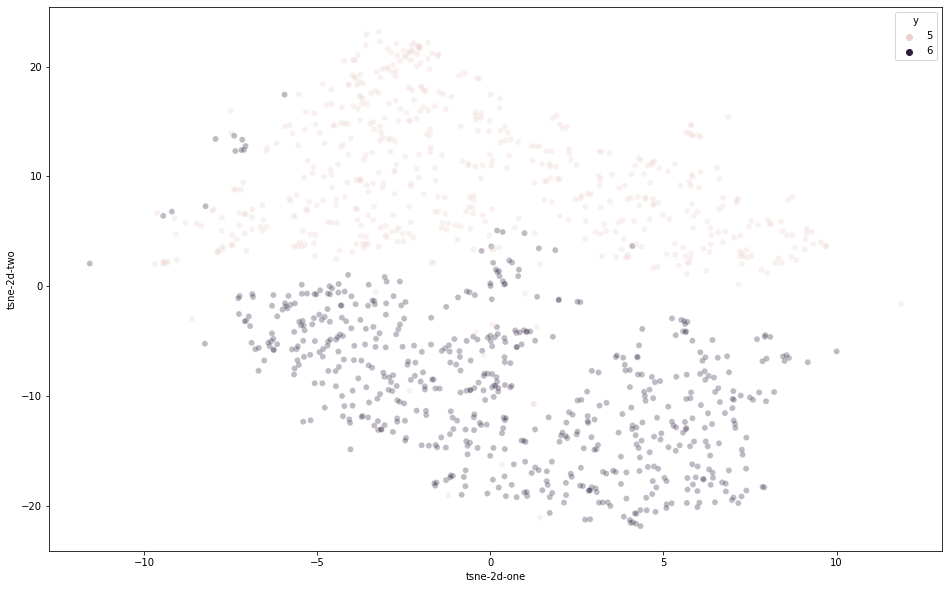

In [ ]:
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['y'] = y_test

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    data=df_subset,
    legend="full",
    alpha=0.3
)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(random_state=0).fit(flat_enc_img, y_test)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


1.0

# Multiple input 

https://blog.paperspace.com/combining-multiple-features-outputs-keras/

In [ ]:
latent_dim = 128

# sample function for variational autoencoder
def sample_z(args):
    mu, log_var = args
    batch = K.shape(mu)[0]
    eps = K.random_normal(shape=(batch, latent_dim), mean=0., stddev=1.)
    return mu + K.exp(log_var / 2) * eps

In [ ]:
input_img = tf.keras.Input(shape=(32, 32, 3))
input_label = tf.keras.Input(shape=(10,))

x = Conv2D(64, (3, 3), padding='same')(input_img)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
# Flatten layer
x = Flatten()(x)
x = concatenate([x,input_label])
# Sample layer
mu = Dense(latent_dim)(x)
log_var = Dense(latent_dim)(x)
latent_repr = Lambda(sample_z)([mu, log_var])

x = Dense(256, input_dim=latent_dim)(latent_repr)
x = Reshape((4, 4, 16))(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = tf.keras.Model(inputs=[input_img,input_label], outputs=decoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 32, 32, 64)   1792        ['input_3[0][0]']                
                                                                                                  
 leaky_re_lu_6 (LeakyReLU)      (None, 32, 32, 64)   0           ['conv2d_7[0][0]']               
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 64)  0           ['leaky_re_lu_6[0][0]']          
                                                                                            

In [ ]:
autoencoder.fit(x=[x_train, y_train_cat], y=x_train,
                epochs=30,
                batch_size=64,
                shuffle=True,
                validation_data=([x_val, y_val_cat], x_val),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/30
625/625 [==============================] - 258s 410ms/step - loss: 0.5957 - val_loss: 0.5774
Epoch 2/30
625/625 [==============================] - 257s 411ms/step - loss: 0.5772 - val_loss: 0.5730
Epoch 3/30
625/625 [==============================] - 260s 415ms/step - loss: 0.5734 - val_loss: 0.5696
Epoch 4/30
625/625 [==============================] - 257s 412ms/step - loss: 0.5710 - val_loss: 0.5675
Epoch 5/30
625/625 [==============================] - 271s 434ms/step - loss: 0.5698 - val_loss: 0.5667
Epoch 6/30
625/625 [==============================] - 297s 475ms/step - loss: 0.5683 - val_loss: 0.5658
Epoch 7/30
625/625 [==============================] - 283s 453ms/step - loss: 0.5673 - val_loss: 0.5646
Epoch 8/30
625/625 [==============================] - 296s 474ms/step - loss: 0.5665 - val_loss: 0.5634
Epoch 9/30
625/625 [==============================] - 262s 419ms/step - loss: 0.5658 - val_loss: 0.5631
Epoch 10/30
625/625 [==============================] - 260s 416m

In [ ]:
encoder = tf.keras.Model(inputs=[input_img,input_label], outputs= mu)

encoded_x_train = encoder.predict([x_train,y_train_cat])

encoded_x_test = encoder.predict([x_test,y_test_cat])

y_new = y_test_cat - y_test_cat
encoded_x_test_0 = encoder.predict([x_test,y_new])

In [ ]:
y_train = np.argmax(y_train_cat, axis=1, out=None)
y_test = np.argmax(y_test_cat, axis=1, out=None)
y_new_test = np.argmax(y_new, axis=1, out=None)